In [1]:
# Se importan las librerías necesarias para el análisis:
# - pandas: manipulación de datos estructurados
# - StandardScaler: estandarización de variables numéricas
# - KMeans: algoritmo de clustering no supervisado
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


# Se carga el dataset preprocesado con características musicales desde archivo parquet
df = pd.read_parquet('songs_optimized.parquet')

In [2]:
# Se visualizan las primeras 5 filas del DataFrame para inspeccionar su estructura
df.head()

,Artist(s),song,text,Length,emotion,Genre,Album,Release Date,Key,Tempo,...,Good for Morning Routine,Similar Artist 1,Similar Song 1,Similarity Score 1,Similar Artist 2,Similar Song 2,Similarity Score 2,Similar Artist 3,Similar Song 3,Similarity Score 3
0,!!!,Even When the Waters Cold,Friends told her she was better off at the bot...,03:47,sadness,hip hop,Thr!!!er,29th April 2013,D min,105,...,False,Corey Smith,If I Could Do It Again,0.986061,Toby Keith,Drinks After Work,0.983719,Space,Neighbourhood,0.983236
1,!!!,One Girl / One Boy,"Well I heard it, playing soft From a drunken b...",04:03,sadness,hip hop,Thr!!!er,29th April 2013,A# min,117,...,False,Hiroyuki Sawano,BRE@TH//LESS,0.995409,When In Rome,Heaven Knows,0.990905,Justice Crew,Everybody,0.984483
2,!!!,Pardon My Freedom,"Oh my god, did I just say that out loud? Shoul...",05:51,joy,hip hop,Louden Up Now,8th June 2004,A Maj,121,...,False,Ricky Dillard,More Abundantly Medley Live,0.993176,Juliet,Avalon,0.965147,The Jacksons,Lovely One,0.956752
3,!!!,Ooo,[Verse 1] Remember when I called you on the te...,03:44,joy,hip hop,As If,16th October 2015,A min,122,...,False,Eric Clapton,Man Overboard,0.992749,Roxette,Don't Believe In Accidents,0.991494,Tiwa Savage,My Darlin,0.990381
4,!!!,Freedom 15,[Verse 1] Calling me like I got something to s...,06:00,joy,hip hop,As If,16th October 2015,F min,123,...,False,Cibo Matto,Lint Of Love,0.981610,Barrington Levy,Better Than Gold,0.981524,Freestyle,Its Automatic,0.981415


In [3]:
# Se revisan los tipos de datos de cada columna para identificar columnas numéricas, categóricas o mal tipificadas
df.dtypes

Artist(s)                         category
song                                object
text                                object
Length                              object
emotion                           category
Genre                             category
Album                             category
Release Date                        object
Key                               category
Tempo                                int64
Loudness (db)                       object
Time signature                    category
Explicit                              bool
Popularity                           uint8
Energy                               uint8
Danceability                         uint8
Positiveness                         uint8
Speechiness                          uint8
Liveness                             uint8
Acousticness                         uint8
Instrumentalness                     uint8
Good for Party                        bool
Good for Work/Study                   bool
Good for Re

In [4]:
# Se identifican automáticamente las columnas de tipo booleano
bool_cols = df.select_dtypes(include=['bool']).columns

# Se convierten las variables booleanas a valores numéricos (0 y 1), requeridos para el modelo
df[bool_cols] = df[bool_cols].astype(int)

# Se visualiza una muestra de las columnas booleanas ya transformadas
print(df[bool_cols].head())

   Explicit  Good for Party  Good for Work/Study  \
0         0               0                    0   
1         0               0                    0   
2         0               0                    0   
3         0               0                    0   
4         0               0                    0   

   Good for Relaxation/Meditation  Good for Exercise  Good for Running  \
0                               0                  0                 0   
1                               0                  0                 0   
2                               0                  1                 0   
3                               0                  1                 0   
4                               0                  1                 0   

   Good for Yoga/Stretching  Good for Driving  Good for Social Gatherings  \
0                         0                 0                           0   
1                         0                 0                           0   
2          

In [5]:
# Se normaliza la columna 'Genre' para extraer solo el primer género en caso de múltiples etiquetas
# Esto ayuda a simplificar la categorización y análisis posterior
df['Genre_principal'] = df['Genre'].astype(str).str.lower().str.split(',|/').str[0].str.strip()

In [6]:
# Se visualizan los géneros principales únicos identificados tras la limpieza
df['Genre_principal'].unique()

array(['hip hop', 'jazz', 'indie rock', 'classical', 'rock', 'rap',
       'trance', 'country', 'electronic', 'pop', 'chillout',
       'alternative rock', 'hip-hop', 'punk', 'k-pop', 'metal', 'folk',
       'trap', 'cloud rap', 'reggae', 'industrial', 'soul', 'punk rock',
       'garage rock', 'nu metal', 'experimental', 'blues', 'black metal',
       'drum and bass', 'dance', 'pop rock', 'funk', 'hard rock',
       'heavy metal', 'power metal', 'soundtrack', 'hardcore', 'house',
       'math rock', 'indie', 'melodic death metal', 'synthpop', 'techno',
       'post-punk', 'indie pop', 'post-hardcore', 'lo-fi', 'shoegaze',
       'electropop', 'death metal', 'latin', 'progressive rock',
       'dream pop', 'worship', 'psychedelic rock', 'j-pop', 'doom metal',
       'gospel', 'disco', 'ambient', 'comedy', 'christian', 'metalcore',
       'new wave', 'acoustic', 'progressive metal', 'rnb', 'trip-hop',
       'pop punk', 'dancehall', 'emo', 'dubstep', 'swing', 'thrash metal',
       'bri

In [7]:
# Distribución de frecuencias por género principal
df['Genre_principal'].value_counts()

Genre_principal
hip hop             271314
rock                 69646
pop                  32052
alternative rock     13209
electronic           10730
                     ...  
psychedelic             76
alt-country             56
chillout                48
britpop                 46
reggaeton               10
Name: count, Length: 88, dtype: int64

In [8]:
# Función para convertir una duración en formato 'mm:ss' a segundos
# Se incluye manejo de errores para valores nulos o mal formateados
def convertir_a_segundos(tiempo):
    try:
        minutos, segundos = map(int, tiempo.split(':'))
        return minutos * 60 + segundos
    except:
        return None  # En caso de error, se retorna un valor nulo

# Se aplica la conversión a la columna 'Length' y se crea una nueva columna numérica
df['Duration_sec'] = df['Length'].astype(str).apply(convertir_a_segundos)

# Se elimina la columna original 'Length', ya que ahora contamos con la versión numérica
df.drop(columns=['Length'], inplace=True)

In [9]:
# 1. Eliminación de columnas irrelevantes para el análisis de clustering
# Se remueven columnas relacionadas con metadatos y recomendaciones previas que no aportan al modelo
columns_to_drop = [
    'Similar Song 1', 'Similar Song 2', 'Similar Song 3',
    'Album', 'Release Date', 'text','Similar Artist 1', 
    'Similarity Score 1', 'Similar Artist 2', 
    'Similarity Score 2', 'Similar Artist 3', 
    'Similarity Score 3', 'Key',
]

# Se eliminan solo si existen en el DataFrame, evitando errores en caso de nombres ausentes
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns], errors='ignore')

# Se visualiza la estructura del DataFrame tras la eliminación
print(df.columns)

Index(['Artist(s)', 'song', 'emotion', 'Genre', 'Tempo', 'Loudness (db)',
       'Time signature', 'Explicit', 'Popularity', 'Energy', 'Danceability',
       'Positiveness', 'Speechiness', 'Liveness', 'Acousticness',
       'Instrumentalness', 'Good for Party', 'Good for Work/Study',
       'Good for Relaxation/Meditation', 'Good for Exercise',
       'Good for Running', 'Good for Yoga/Stretching', 'Good for Driving',
       'Good for Social Gatherings', 'Good for Morning Routine',
       'Genre_principal', 'Duration_sec'],
      dtype='object')


In [10]:
# Se eliminan registros duplicados basados en el nombre de la canción, artista y duración
# Esto evita que se repitan versiones idénticas de una misma canción en el análisis
df = df.drop_duplicates(subset=["song", "Artist(s)", "Duration_sec"])

In [11]:
# Se listan las emociones únicas presentes en la columna 'emotion' (omitiendo valores nulos)
# Esto permite entender cómo se distribuyen las emociones categóricas en el dataset
for e in df['emotion'].dropna().unique():
    print(f"- {e}")

- sadness
- joy
- love
- surprise
- anger
- fear
- angry
- True
- thirst
- confusion
- pink
- interest
- Love


In [12]:
df['emotion'].value_counts(dropna=False)

emotion
joy          189371
sadness      156813
anger         95489
fear          26001
love          25379
surprise       4974
True             17
Love              2
pink              2
angry             1
confusion         1
interest          1
thirst            1
Name: count, dtype: int64

In [13]:
# 1. Se crea una copia del DataFrame original para trabajar sobre una versión editable sin afectar los datos base
df_cluster = df.copy()

# 2. Limpieza de la columna 'emotion'
# Se unifican valores inconsistentes o ruidosos que no representan emociones válidas
emotion_map = {
    'love': 'love',
    'Love': 'love',
    'angry': 'anger',
    'true': 'unknown',
    'pink': 'unknown',
    'thirst': 'unknown',
    'confusion': 'unknown',
    'interest': 'unknown'
}

df_cluster['emotion'] = (
    df_cluster['emotion']
    .astype(str)
    .str.strip()
    .str.lower()
    .replace(emotion_map)
    .fillna('unknown')
)


# 3. Codificación one-hot de las emociones para convertirlas en variables binarias
df_cluster = pd.get_dummies(df_cluster, columns=['emotion'])

# Se visualiza la estructura de las columnas de emociones
[col for col in df_cluster.columns if col.startswith('emotion_')]

['emotion_anger',
 'emotion_fear',
 'emotion_joy',
 'emotion_love',
 'emotion_sadness',
 'emotion_surprise',
 'emotion_unknown']

In [14]:
# Se identifican las nuevas columnas booleanas generadas por el one-hot encoding de emociones
bool_cols = df_cluster.select_dtypes(include='bool').columns

# Se transforman estas columnas a tipo entero (0/1), necesario para KMeans
df_cluster[bool_cols] = df_cluster[bool_cols].astype(int)

In [15]:
# Se revisan los tipos de datos finales del DataFrame para verificar la preparación de las variables numéricas
df_cluster.dtypes

Artist(s)                         category
song                                object
Genre                             category
Tempo                                int64
Loudness (db)                       object
Time signature                    category
Explicit                             int32
Popularity                           uint8
Energy                               uint8
Danceability                         uint8
Positiveness                         uint8
Speechiness                          uint8
Liveness                             uint8
Acousticness                         uint8
Instrumentalness                     uint8
Good for Party                       int32
Good for Work/Study                  int32
Good for Relaxation/Meditation       int32
Good for Exercise                    int32
Good for Running                     int32
Good for Yoga/Stretching             int32
Good for Driving                     int32
Good for Social Gatherings           int32
Good for Mo

In [16]:
# Paso 1: Normalizar los valores de la columna 'Genre_principal'
df_cluster['Genre_principal'] = df_cluster['Genre_principal'].astype(str).str.lower().str.strip()

# Paso 2: Función para asignar grupos intermedios de género musical
def asignar_genero_intermedio(g):
    if not isinstance(g, str):
        return 'other'

    g = g.lower().strip()

    # Rock y variantes
    if g in [
        'rock', 'alternative rock', 'classic rock', 'hard rock',
        'indie rock', 'garage rock', 'math rock', 'shoegaze',
        'post-punk', 'grunge', 'britpop', 'pop punk', 'punk', 'punk rock'
    ]:
        return 'rock'

    # Pop y derivados comerciales
    elif g in [
        'pop', 'electropop', 'synthpop', 'pop rock', 'mainstream pop'
    ]:
        return 'pop'

    # Indie pop y dream pop como categoría aparte
    elif g in ['indie pop', 'dream pop']:
        return 'indie pop / dream pop'

    # Hip hop, rap, trap
    elif g in [
        'hip hop', 'hip-hop', 'rap', 'trap', 'emo rap',
        'grime', 'cloud rap'
    ]:
        return 'hip hop / rap'

    # Electrónica bailable (club)
    elif g in [
        'electronic', 'house', 'techno', 'electro', 'trance',
        'edm', 'dance', 'future bass', 'disco', 'dubstep'
    ]:
        return 'electronic (club)'

    # Electrónica relajada
    elif g in [
        'lo-fi', 'chillwave', 'downtempo', 'ambient', 'trip-hop', 'chillout'
    ]:
        return 'chill / downtempo'

    # Experimental, alternativa dura
    elif g in [
        'experimental', 'alternative', 'post-hardcore', 'screamo',
        'industrial', 'emo', 'new wave', 'noise', 'indie', 'hardcore'
    ]:
        return 'experimental / alternativa'

    # Metal y subgéneros
    elif g in [
        'metal', 'heavy metal', 'nu metal', 'deathcore',
        'melodic death metal', 'doom metal', 'thrash metal',
        'progressive metal', 'black metal', 'metalcore', 'power metal',
        'death metal'
    ]:
        return 'metal'

    # Psicodélico y progresivo
    elif g in [
        'psychedelic', 'psychedelic rock', 'progressive rock', 'space rock'
    ]:
        return 'psicodélico / progresivo'

    # Folk, country, americana
    elif g in [
        'folk', 'country', 'alt-country', 'americana', 'acoustic'
    ]:
        return 'folk / country'

    # Jazz, soul, funk, blues
    elif g in [
        'jazz', 'blues', 'soul', 'funk', 'swing'
    ]:
        return 'jazz / soul / funk'

    # R&B moderno
    elif g in [
        'r&b', 'rnb', 'neo soul'
    ]:
        return 'r&b'

    # Clásica, espiritual, bandas sonoras
    elif g in [
        'classical', 'soundtrack', 'worship', 'gospel', 'christian'
    ]:
        return 'clásica / espiritual'

    # Reggae y estilos caribeños
    elif g in [
        'reggae', 'dancehall', 'dub', 'reggaeton'
    ]:
        return 'reggae / caribeño'

    # Géneros latinos
    elif g in ['latin', 'salsa', 'cumbia', 'bachata']:
        return 'latino'

    # Pop asiático
    elif g in ['k-pop', 'j-pop', 'c-pop', 'v-pop', 'mandopop']:
        return 'asian pop'

    # Acústico, soft rock, cantautor
    elif g in ['singer-songwriter', 'soft rock', 'acoustic pop', 'folk pop']:
        return 'acoustic / soft rock'

    # Humor, misceláneo
    elif g in ['comedy', 'novelty']:
        return 'comedy / otros'

    # Otros géneros no contemplados
    else:
        return 'other'

# Paso 3: Aplicar la función al DataFrame
df_cluster['Genre_grupo'] = df_cluster['Genre_principal'].apply(asignar_genero_intermedio)

# Paso 4: Mostrar la distribución final de canciones por grupo
print("Distribución de canciones por grupo de género:")
print(df_cluster['Genre_grupo'].value_counts())


Distribución de canciones por grupo de género:
Genre_grupo
hip hop / rap                 240220
rock                          102935
pop                            44012
folk / country                 19731
jazz / soul / funk             19577
metal                          17266
electronic (club)              15383
experimental / alternativa      8943
clásica / espiritual            7611
reggae / caribeño               6235
indie pop / dream pop           5017
psicodélico / progresivo        3707
chill / downtempo               2311
other                           2022
asian pop                       1362
comedy / otros                   871
r&b                              496
latino                           353
Name: count, dtype: int64


In [17]:
# Codificar la variable 'Genre_grupo' con one-hot encoding (dummies)
df_cluster = pd.get_dummies(df_cluster, columns=['Genre_grupo'], prefix='Genre')

# Mostrar un ejemplo de las columnas creadas para verificar que funcionó
print(df_cluster.filter(like='Genre_').head())

# Revisar el tipo de datos de las columnas dummy generadas
print(df_cluster.filter(like='Genre_').dtypes.value_counts())


  Genre_principal  Genre_asian pop  Genre_chill / downtempo  \
0         hip hop            False                    False   
1         hip hop            False                    False   
2         hip hop            False                    False   
3         hip hop            False                    False   
4         hip hop            False                    False   

   Genre_clásica / espiritual  Genre_comedy / otros  Genre_electronic (club)  \
0                       False                 False                    False   
1                       False                 False                    False   
2                       False                 False                    False   
3                       False                 False                    False   
4                       False                 False                    False   

   Genre_experimental / alternativa  Genre_folk / country  \
0                             False                 False   
1                 

In [18]:
# Convertir columnas booleanas a enteros (0 y 1) si existen
for col in df_cluster.select_dtypes(include='bool').columns:
    df_cluster[col] = df_cluster[col].astype(int)


In [19]:
# Verificar si todas están en int para aplicar en el modelo
df_cluster.dtypes

Artist(s)                           category
song                                  object
Genre                               category
Tempo                                  int64
Loudness (db)                         object
Time signature                      category
Explicit                               int32
Popularity                             uint8
Energy                                 uint8
Danceability                           uint8
Positiveness                           uint8
Speechiness                            uint8
Liveness                               uint8
Acousticness                           uint8
Instrumentalness                       uint8
Good for Party                         int32
Good for Work/Study                    int32
Good for Relaxation/Meditation         int32
Good for Exercise                      int32
Good for Running                       int32
Good for Yoga/Stretching               int32
Good for Driving                       int32
Good for S

In [20]:
# Ver columnas que no son tipo int o float (posibles problemas)
print(df_cluster.select_dtypes(exclude=['int', 'float']).dtypes)

Artist(s)           category
song                  object
Genre               category
Loudness (db)         object
Time signature      category
Popularity             uint8
Energy                 uint8
Danceability           uint8
Positiveness           uint8
Speechiness            uint8
Liveness               uint8
Acousticness           uint8
Instrumentalness       uint8
Genre_principal       object
dtype: object


In [21]:
df_cluster = df_cluster.drop(columns=['Genre'])
df_cluster = df_cluster.drop(columns=['Genre_principal'])

In [22]:
# 1️ Identificación de columnas generadas por el one-hot encoding de 'Genre_grupo'
# Estas columnas binarizadas se usarán como parte del conjunto de variables explicativas
genre_grupo_cols = [col for col in df_cluster.columns if col.startswith('Genre_')]

# 2️ Identificación de columnas codificadas desde la variable 'emotion'
emotion_cols = [col for col in df_cluster.columns if col.startswith('emotion_')]

# 3️ Definición del conjunto final de variables (features) para el modelo de clustering
# Se incluyen variables acústicas, emocionales, de contexto (actividades) y los géneros codificados
features = [
    'Energy', 'Danceability', 'Tempo',
    'Positiveness', 'Speechiness', 'Liveness',
    'Acousticness', 'Instrumentalness',
    'Duration_sec',
    'Good for Party', 'Good for Work/Study',
    'Good for Relaxation/Meditation', 'Good for Exercise',
    'Good for Running', 'Good for Yoga/Stretching',
    'Good for Driving', 'Good for Social Gatherings',
    'Good for Morning Routine'
] + emotion_cols + genre_grupo_cols


In [23]:
# Verificar si todas las columnas listadas existen en el DataFrame
missing = [col for col in features if col not in df_cluster.columns]

if missing:
    print("Columnas faltantes en df_cluster:", missing)
else:
    print("Todas las columnas existen en df_cluster.")


Todas las columnas existen en df_cluster.


In [24]:
# Definición de pesos para cada dimensión de las features usadas en la recomendación

# Número de columnas (features) por tipo
n_acusticas = 9        # Atributos como danceability, energy, tempo, etc.
n_contexto = 9         # Variables binarias tipo good_for_party, good_for_work, etc.
n_emociones = len(emotion_cols)        # Columnas que representan emociones
n_generos = len(genre_grupo_cols)      # Columnas dummy de géneros (e.g., Genre_pop, Genre_rock...)

# Asignación de pesos a cada tipo de feature:
pesos = (
    [2.5] * n_acusticas +
    [2.5] * n_contexto +
    [2.0] * n_emociones +
    [2.5] * n_generos
)

# Conversión a array NumPy para usar en cálculos vectorizados
pesos = np.array(pesos)


In [25]:
assert len(pesos) == len(features), f"Error: pesos ({len(pesos)}) y features ({len(features)}) no coinciden"
print("Vector de pesos construido correctamente.")

Vector de pesos construido correctamente.


In [26]:
# Revisar si alguna de las columnas en `features` no es numérica
non_numeric = df_cluster[features].select_dtypes(exclude=['int', 'float', 'uint8']).columns
print("Columnas no numéricas en features:", list(non_numeric))


Columnas no numéricas en features: []


In [139]:
# 4️ Escalamiento de las variables seleccionadas
# Se estandariza la escala de los datos utilizando StandardScaler para mejorar la performance del modelo KMeans
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster[features])
X_ponderado = X_scaled * pesos

# 5️ Entrenamiento del modelo de clustering KMeans con 190 clusters
# El número de clusters puede ajustarse según evaluación exploratoria
kmeans = KMeans(n_clusters=190, n_init=10, random_state=42)
df_cluster['cluster'] = kmeans.fit_predict(X_ponderado)

# 6️ Función de recomendación de canciones basada en cluster
# Selecciona canciones aleatorias dentro del cluster especificado
def recomendar_canciones(df, cluster_id, n=10):
    canciones = df[df['cluster'] == cluster_id]
    return canciones[['song', 'Artist(s)', 'cluster']].sample(n=min(n, len(canciones)))

In [545]:
from sklearn.utils import resample  # Importa una función para tomar muestras aleatorias del dataset
from sklearn.metrics import silhouette_score

#  Paso 1: Tomar una muestra aleatoria del dataset escalado
# Debido a que calcular el silhouette score en los 600.000+ registros es muy costoso,
# se toma una muestra representativa de 100.000 observaciones.
X_sample = resample(X_scaled, n_samples=100000, random_state=42)

#  Paso 2: Evaluar múltiples valores de k (número de clusters) usando silhouette score
# Se prueba con valores de k desde 5 hasta 45 (inclusive), en incrementos de 5.
for k in range(190, 210, 10):
    # Entrena un modelo KMeans con el número de clusters actual
    model = KMeans(n_clusters=k, random_state=42, n_init=10)
    
    # Ajusta el modelo a la muestra y obtiene las etiquetas de cluster para cada punto
    labels = model.fit_predict(X_sample)
    
    # Calcula el silhouette score, que mide la calidad del clustering (valores cercanos a 1 son mejores)
    score = silhouette_score(X_sample, labels)
    
    # Imprime el valor de k y su correspondiente silhouette score
    print(f'k={k}, silhouette score={score:.3f}')


k=190, silhouette score=0.192
k=200, silhouette score=0.189


In [153]:
#EjEMPLO de cluster
recomendar_canciones(df_cluster, cluster_id=173, n=10)

,song,Artist(s),cluster
208678,SUHO - Decanting English Translation,Imee Ooi,173
480506,Beyond the Years,The Neal Morse Band,173
513919,Chef Trez vs. Loso,Ultimate Rap League,173
529099,Vallejo,Ween,173
379549,Shashwot Khadka - Batash English Translation,"Qari Al Sheikh Abdul Basit Abdul Samad,Marmadu...",173
185320,A Woman's Gotta Have It,Grant Green,173
513934,DNA vs. Chilla Jones,"Ultimate Rap League,DNA,Serius Jones",173
302634,"Achilles, Agony And Ecstasy In Eight Parts",Manowar,173
368141,Runaway Jim,Phish,173
538292,Ghali - Habibi English Translation,xemgin neco,173


In [140]:
# Función principal de recomendación.

def recomendar_por_grupo(df_cluster, song_tuples, features, scaler, kmeans, pesos, n=10, min_cluster_size=100):
    """
    Recomienda canciones similares a un grupo de entrada entregado por el usuario,
    utilizando el perfil acústico-emocional promedio del grupo base.

    Parámetros:
    - df_cluster: DataFrame con todas las canciones, sus atributos (features), y cluster asignado.
    - song_tuples: Lista de tuplas (nombre_canción, nombre_artista) como input del usuario.
    - features: Lista de columnas numéricas (features acústicas, contextuales, emocionales, etc.) para comparación.
    - scaler: Objeto de escalado (StandardScaler, MinMaxScaler, etc.) ya ajustado.
    - kmeans: Modelo de clustering KMeans ya entrenado.
    - pesos: Vector NumPy con los pesos asociados a cada feature.
    - n: Número de canciones a recomendar (por defecto 10).
    - min_cluster_size: Tamaño mínimo del cluster considerado válido para recomendar.

    Retorna:
    - DataFrame con canciones recomendadas más cercanas al perfil promedio del input.
    """

    # 1. Normaliza títulos y artistas (input + dataset) para comparación robusta
    song_tuples = [(s.lower().strip(), a.lower().strip()) for s, a in song_tuples]
    df_cluster['song_normalized'] = df_cluster['song'].str.lower().str.strip()
    df_cluster['artist_normalized'] = df_cluster['Artist(s)'].str.lower().str.strip()

    # 2. Selecciona canciones del dataset que coincidan con el título exacto
    #     y contengan al artista indicado (útil para colaboraciones)
    grupo = df_cluster[
        df_cluster.apply(
            lambda row: any(
                (row['song_normalized'] == s and s_artista in row['artist_normalized'])
                for s, s_artista in song_tuples
            ),
            axis=1
        )
    ]

    # 2.1 Muestra advertencia si hay canciones del input que no fueron encontradas en el dataset
    canciones_input = set(song_tuples)
    canciones_encontradas = set([
        (row['song_normalized'], s_artista)
        for _, row in grupo.iterrows()
        for s, s_artista in song_tuples
        if row['song_normalized'] == s and s_artista in row['artist_normalized']
    ])
    no_encontradas = canciones_input - canciones_encontradas

    if no_encontradas:
        print("Canciones NO encontradas en el dataset (nombre + artista):")
        for song, artist in no_encontradas:
            print(f" - '{song}' — {artist}")
        print("\n Solo se usaron las canciones encontradas para la recomendación.\n")

    # 2.2 Si no se encontró ninguna canción válida, se detiene el proceso
    if grupo.empty:
        raise ValueError("No se encontraron canciones válidas en el DataFrame. Verifica nombre y artista.")

    # 3. Escala y pondera las features del grupo base
    grupo_scaled = scaler.transform(grupo[features]) * pesos

    # 4. Calcula el vector promedio del grupo base
    promedio = grupo_scaled.mean(axis=0).reshape(1, -1)

    # 5. Ordena todos los clusters por cercanía al vector promedio
    distancias_clusters = np.linalg.norm(kmeans.cluster_centers_ - promedio, axis=1)
    clusters_ordenados = np.argsort(distancias_clusters)

    # 6. Filtra clusters que tengan al menos 'min_cluster_size' canciones
    cluster_counts = df_cluster['cluster'].value_counts()
    clusters_validos = cluster_counts[cluster_counts >= min_cluster_size].index.tolist()

    # 7. Detecta los 3 géneros predominantes en el grupo base para filtrar luego
    columnas_genero_dummy = [col for col in df_cluster.columns if col.startswith('Genre_')]
    if not columnas_genero_dummy:
        raise ValueError("No se encontraron columnas dummy de género (prefijo 'Genre_').")

    suma_generos = grupo[columnas_genero_dummy].sum().sort_values(ascending=False)
    generos_deseados = suma_generos.head(3).index.tolist()

    # 8. Busca el primer cluster válido y cercano que tenga canciones con géneros similares
    cluster_predicho = None
    candidatos = pd.DataFrame()

    for cid in clusters_ordenados:
        if cid not in clusters_validos:
            continue

        # Filtra canciones del cluster, excluyendo las del grupo base
        subset = df_cluster[
            (df_cluster['cluster'] == cid) &
            (~df_cluster.apply(
                lambda row: any(
                    (row['song_normalized'] == s and s_artista in row['artist_normalized'])
                    for s, s_artista in song_tuples
                ),
                axis=1
            ))
        ].copy()

        if len(subset) == 0:
            continue

        # Filtra solo canciones que compartan algún género con el grupo base
        filtro_genero = subset[generos_deseados].sum(axis=1) > 0
        subset = subset[filtro_genero]

        # Si hay candidatos válidos, se guarda ese cluster y se detiene la búsqueda
        if len(subset) > 0:
            cluster_predicho = cid
            candidatos = subset
            break

    # Si no se encontró ningún cluster adecuado, se notifica
    if cluster_predicho is None or candidatos.empty:
        raise ValueError("No se encontró un cluster cercano con canciones y géneros similares.")

    # 9. Escala y pondera los candidatos del cluster elegido
    candidatos_scaled = scaler.transform(candidatos[features]) * pesos

    # 10. Calcula la distancia de cada candidato al vector promedio del grupo base
    distancias = np.linalg.norm(candidatos_scaled - promedio, axis=1)
    candidatos['distancia_perfil'] = distancias

    # 11. Ordena por cercanía al perfil promedio y devuelve el top n
    recomendaciones = candidatos.sort_values(by='distancia_perfil').head(min(n, len(candidatos)))

    return recomendaciones[['song', 'Artist(s)', 'cluster', 'distancia_perfil']]


In [141]:
# EJ1
mis_canciones2 = [
    ('1979', 'The Smashing Pumpkins'),
    ('Hard to explain', 'The Strokes'),
    ('This charming man', 'The Smiths'),
    ('Salad days', 'Mac DeMarco'),
    ('Killing an arab', 'The Cure'),
    ('Just like heaven', 'The Cure')
]

recomendar_por_grupo(df_cluster, mis_canciones2, features, scaler, kmeans, pesos, n=10)

,song,Artist(s),cluster,distancia_perfil
19205,Artifact,Allah-Las,79,4.441466
180412,Kill the Sexplayer,Girls Against Boys,79,4.443636
374155,Give/Take,Porridge Radio,79,4.583788
9419,Love Bomb,AC/DC,79,4.620462
270397,Morning High,La Luz,79,4.813004
211445,Mascara,Interpol,79,4.828269
378068,Too Many Jewels,Protomartyr,79,4.838077
60836,Flowerparts,Bob Schneider,79,4.854967
489368,Low Lays The Devil,The Veils,79,4.893180
56829,Im All Over the Place Mystic Mama,Bleached,79,4.947973


In [143]:
# EJ2
songs = [
    ('Exchange', 'Bryson Tiller'),
    ('Right My Wrongs', 'Bryson Tiller'),
    ('Let Me Explain', 'Bryson Tiller'),
    ('Moonlight', 'XXXTENTACION'),
    ('Break From Toronto', 'Partynextdoor'),
    ('Next to you', 'Bryson Tiller'),
]

recomendar_por_grupo(df_cluster, songs, features, scaler, kmeans, pesos, n=10)

,song,Artist(s),cluster,distancia_perfil
242618,Hell Yeah,"Juelz Santana,August Alsina",3,6.519754
43779,The Musical,Bears In Trees,3,6.555834
582,Forget It,$uicideboy$,3,6.561487
183536,Airport Bar,goodboy noah,3,6.563495
32445,Rockstar Baby,Asian Doll,3,6.583768
402161,DSYLM Dont Say You Love Me,Rubee Rayne,3,6.586260
440923,Give A Little,Stellar,3,6.592874
227527,Conviction,JESSIA,3,6.600539
237537,Storm,JON VINYL,3,6.613605
222224,I Think Im Sick,Jaxxon D. Silva,3,6.616932


In [145]:
# EJ3
songs2 = [
    ('Exchange', 'Bryson Tiller'),
    ('Right My Wrongs', 'Bryson Tiller'),
    ('Let Me Explain', 'Bryson Tiller'),
    ('Back to Sleep', 'Chris Brown'),
    ('Break from Toronto', 'PARTYNEXTDOOR'),
    ('Persian Rugs', 'PARTYNEXTDOOR'),
    ('Tempo', 'Chris Brown'),
    ('Say It', 'Tory Lanez'),
    ('Overtime', 'Bryson Tiller'),                      
    ('Back to Love', 'Chris Brown'),                    
    ('Belong to the City', 'PARTYNEXTDOOR'),            
    ('With You', 'Chris Brown'),                        
    ('Blessed', 'Daniel Caesar'),                                                                         
    ('Sure Thing', 'Miguel'),                           
    ('Insecure', 'Brent Faiyaz'),
    ('Do Not Disturb', 'Drake'),
    ('Still Think About You', 'A Boogie Wit Da Hoodie')
]

recomendar_por_grupo(df_cluster, songs2, features, scaler, kmeans, pesos, n=10)

,song,Artist(s),cluster,distancia_perfil
237948,Get This Right Outtake,"Jonathan Groff,Original Broadway Cast of Hamilton",35,7.399614
508144,So Stressed,"Trippie Redd,Yung LB",35,7.402371
431066,Now That Youre Mine,Snass,35,7.404739
236545,Normal,Johnny Polygon,35,7.417086
166199,Linen,Fortunes.,35,7.424640
354783,Couldve Been,Oshea,35,7.425096
450724,No Hard Feelings,Sydney Renae,35,7.428082
226377,Searchin,"Jeremy Irons,Whoopi Goldberg,Cheech Marin,Jim ...",35,7.433059
455562,Take You Down,"Tech N9ne Collabos,Mackenzie Nicole,Ryan Bradl...",35,7.454645
204430,Sun Goddess,Hurt Everybody,35,7.455861


In [146]:
# EJ4
songs_5 = [
    ('Only Your Sins Know', 'Subterranean Street Society'),
    ('Moonlight', 'XXXTENTACION'),
    ('Cross My Heart', 'Nezzy'),
    ('Youth', 'Daughter'),
    ('Night Swim', 'Josef Salvat')
]

recomendar_por_grupo(df_cluster, songs_5, features, scaler, kmeans, pesos, n=10)

,song,Artist(s),cluster,distancia_perfil
72617,I'll Never Fall In Love Again,"Burt Bacharach,Elvis Costello",3,7.882753
139976,Mutombo,Dwn2earth,3,7.900524
113670,Blue Is Fallin,"David Bromberg,Tim O'Brien",3,7.900662
479655,Wet Cement,The Morning Benders,3,7.907545
365881,Opportunity,Pete Murray,3,7.914336
174163,Coca Cola Cowboy,"Gaither,Mel Tillis",3,7.922895
325733,Sunflower Vol. 6,Molly Tuttle,3,7.923095
361803,High Hope,Patrick Droney,3,7.931994
28018,Ana W Micro,Anys,3,7.948919
17898,Fight for Me,AlicebanD,3,7.971341


In [147]:
# EJ5
songs_10 = songs_5 + [
    ('Airport Bar', 'goodboy noah'),
    ('Let Me Down Slowly', 'Alec Benjamin'),
    ('Lost', 'Frank Ocean'),
    ('Lucid Dreams', 'Juice WRLD'),
    ('Night Shift', 'Lucy Dacus')
]

recomendar_por_grupo(df_cluster, songs_10, features, scaler, kmeans, pesos, n=10)

,song,Artist(s),cluster,distancia_perfil
234907,Avalon,John Moreland,3,7.422572
139976,Mutombo,Dwn2earth,3,7.435884
361803,High Hope,Patrick Droney,3,7.437959
28018,Ana W Micro,Anys,3,7.443117
72617,I'll Never Fall In Love Again,"Burt Bacharach,Elvis Costello",3,7.481311
396758,Dont Hurt Yourself,Roadtrip,3,7.486453
548263,Since We Lost Yall,"Z-Ro,Krayzie Bone",3,7.486481
479655,Wet Cement,The Morning Benders,3,7.507942
445177,Haunted,"Stwo,Sevdaliza",3,7.526111
409083,Reverse Faults,Sampha,3,7.527671


In [148]:
# EJ6
songs_20 = songs_10 + [
    ('Falling', 'Harry Styles'),
    ('Cigarette Daydreams', 'Cage The Elephant'),
    ('Drew Barrymore', 'SZA'),
    ('I Need My Girl', 'The National'),
    ('Unfucktheworld', 'Angel Olsen'),
    ('505', 'Arctic Monkeys'),
    ('I Know The End', 'Phoebe Bridgers'),
    ('Dead To Me', 'Kali Uchis'),
    ('Someone You Loved', 'Lewis Capaldi'),
    ('The Night We Met', 'Lord Huron')
]

recomendar_por_grupo(df_cluster, songs_20, features, scaler, kmeans, pesos, n=10)

,song,Artist(s),cluster,distancia_perfil
139976,Mutombo,Dwn2earth,3,6.890652
234907,Avalon,John Moreland,3,6.917658
486940,The Story Of My Life - Tribute to One Direction,The Story Of My Life,3,6.932140
153695,Losing Hold,"Esterly,Austin Jenckes",3,6.944551
72617,I'll Never Fall In Love Again,"Burt Bacharach,Elvis Costello",3,6.949086
523790,Suck At Love,Violet Days,3,6.955582
234,Mr. Blue,#1 Garth Brooks Tribute Band,3,6.976499
69299,A Song for the Lonely,broox,3,6.987474
149387,Icarus,Emma Blackery,3,6.993478
54707,I Have Nothing,Black Mesa,3,7.011053


In [149]:
# EJ7
songs_conflict = [
    ('Stronger', 'Kanye West'),
    ('Everybody Dies In Their Nightmares', 'XXXTENTACION'),
    ('Toxic', 'Britney Spears'),
    ('drivers license', 'Olivia Rodrigo'),
    ('Jealous', 'Labrinth'),
    ('Power', 'Kanye West'),                    # intensa, agresiva, ego-power
    ('Let Her Go', 'Passenger'),           # melancólica, lenta, folk-pop
    ('Goosebumps', 'Travis Scott'),      # oscura, emocional, con base hip hop/psicodélica
    ('Electric Feel', 'MGMT'),           # psicodélica, sensual, energética
    ('Take Me To Church', 'Hozier')      # intensa, dramática, espiritual
]

recomendar_por_grupo(df_cluster, songs_conflict, features, scaler, kmeans, pesos, n=10)

,song,Artist(s),cluster,distancia_perfil
143869,So Fine,Electric Light Orchestra,170,9.582513
238954,Road to Paradise,Jordin Sparks,170,9.635108
381541,Hair Braider,R. Kelly,170,9.723907
363489,Will You Marry Me?,Paula Abdul,170,9.777117
21678,Green Monkey,America,170,9.785079
451416,Your Friend,T-Pain,170,9.845349
499313,Painting in the Rain,Todrick Hall,170,9.848496
371670,Letter to My Ex,Pleasure P,170,9.858509
87851,Lily,Choker,170,9.869910
226690,Don't Take It Personal,Jermaine Jackson,170,9.895169


In [150]:
# EJ8
songs_soft_emotional = [
    ('Heather', 'Conan Gray'),
    ('IDK You Yet', 'Alexander 23'),
    ('All I Want', 'Kodaline'),
    ('Falling', 'Harry Styles'),
    ('Forever', 'Lewis Capaldi'),
    ('Let Her Go', 'Passenger'),
    ('July', 'Noah Cyrus')
]

recomendar_por_grupo(df_cluster, songs_soft_emotional, features, scaler, kmeans, pesos, n=10)

,song,Artist(s),cluster,distancia_perfil
32094,Dont Call Me Crazy,Ashlee,48,9.415091
547733,The Rain,Yusuf / Cat Stevens,48,9.421368
75565,Consequences Orchestra,Camila Cabello,48,9.447498
395740,Soul Survivor,Rita Ora,48,9.454481
34440,Colorblind,Aura Dione,48,9.464429
417362,Lonesome,SHAED,48,9.471433
529724,Please Stay,Westlife,48,9.473187
45884,Sentimental Guy,Ben Folds,48,9.476446
420214,Live For You,Sheppard,48,9.498415
340498,Heartbreak Weather,Niall Horan,48,9.499787


In [151]:
# EJ9
songs_metal_core = [
    ('Duality', 'Slipknot'),
    ('Bodies', 'Drowning Pool'),
    ('Bleed It Out', 'Linkin Park'),
    ('Break Stuff', 'Limp Bizkit'),
    ('Fight Music', 'D12'),
    ('Coming Undone', 'Korn')
]

recomendar_por_grupo(df_cluster, songs_metal_core, features, scaler, kmeans, pesos, n=10)


,song,Artist(s),cluster,distancia_perfil
388252,Look Around,Red Hot Chili Peppers,10,8.094480
419868,Disco Down,Shed Seven,10,8.114433
359401,Traumatic,Papa Roach,10,8.144576
536813,Filthy,WSTR,10,8.147499
423891,Candle Wax,Sincere Engineer,10,8.151454
536830,The Latest,WSTR,10,8.158288
31605,The Handwritten Letter,AS IT IS,10,8.160900
439316,Speak Slow,Stand Atlantic,10,8.167316
389094,Place Your Hands,Reef,10,8.178613
191678,Overthinking,Hands Like Houses,10,8.185841


In [152]:
# EJ 10
songs_alegres = [
    ('Happy', 'Pharrell Williams'),
    ('Shut Up and Dance', 'WALK THE MOON'),
    ('Electric Love', 'BØRNS'),
    ('On Top of the World', 'Imagine Dragons')
]

recomendar_por_grupo(df_cluster, songs_alegres, features, scaler, kmeans, pesos, n=10)


,song,Artist(s),cluster,distancia_perfil
498729,All I Want,Toad The Wet Sprocket,57,7.699172
499733,Your English Is Good,Tokyo Police Club,57,7.709603
221500,Dont Wanna Go Home,Jason Derulo,57,7.709963
251469,Hummingbird Heartbeat,Katy Perry,57,7.731958
251526,Bad Dream,Katy Perry,57,7.731958
157381,This Heart Attack,Faker,57,7.733261
70645,Shine a Light,Bryan Adams,57,7.746658
295267,Light Up,Luke Bryan,57,7.748535
368905,Take My Hand,Picture This,57,7.751431
444976,Eros and Apollo,Studio Killers,57,7.755051


In [153]:
# EJ 11
songs_high_energy = [
    ('24K Magic', 'Bruno Mars'),
    ('Juice', 'Lizzo'),
    ('Shut Up and Dance', 'WALK THE MOON'),
    ('Summer', 'Calvin Harris'),
    ('Blinding Lights', 'The Weeknd'),
    ('Electric Feel', 'MGMT'),
    ('Good as Hell', 'Lizzo'),
    ('Treasure', 'Bruno Mars'),
    ('Feel It Still', 'Portugal. The Man'),
    ('Shake It Off', 'Taylor Swift')
]



recomendar_por_grupo(df_cluster, songs_high_energy, features, scaler, kmeans, pesos, n=10)

,song,Artist(s),cluster,distancia_perfil
250743,Midnight Sun,Kate Boy,170,9.569637
490295,Love to Lay,The Weeknd,170,9.598309
220363,Faster,Janelle Monáe,170,9.610177
96042,Wish U Were Here,Cody Simpson,170,9.621050
415519,You Forever,Self Esteem,170,9.621777
549009,Need Someone,Zara Larsson,170,9.630488
30124,GENIE,Aries,170,9.634638
71316,Dynamite Tropical Remix,BTS,170,9.638598
77598,Cut to the Feeling,Carly Rae Jepsen,170,9.641847
414364,She Doesnt Mind,Sean Paul,170,9.643108


In [154]:
songs_alegres_espanol = [
    ('F.L.Y.', 'Daddy Yankee'),
    ('Havana Remix', 'Daddy Yankee'),
    ('Alone', 'Romeo santos'),
    ('La Luna', 'Jay Wheeler')
]

recomendar_por_grupo(df_cluster, songs_alegres_espanol, features, scaler, kmeans, pesos, n=10)


,song,Artist(s),cluster,distancia_perfil
172048,Knee Deep Midnight Mix,"Funkadelic,Digital Underground",88,8.440815
252370,Soon as I Get Paid,Keb' Mo',88,8.452112
361734,Pull Up To The Bumper,Patra,88,8.475994
165227,FKN AROUND,Fonk Around,88,8.509166
319075,Wishy Washy,Migos,88,8.509678
475696,All You Gotta Do Is Just Dance,The Just Dance Band,88,8.518717
202156,She Said,Horseshoe G.A.N.G.,88,8.518894
108377,Perfect Picture,"Damian Marley,Stephen Marley",88,8.521609
246407,Fatima,K'NAAN,88,8.522619
295973,Adoration of the Magi,"Lupe Fiasco,Crystal ""Røvél"" Torres",88,8.530772


In [155]:
solitaria1 = [('Hand Of Blood', 'Bullet For My Valentine')]

recomendar_por_grupo(df_cluster, solitaria1, features, scaler, kmeans, pesos, n=10)

,song,Artist(s),cluster,distancia_perfil
138036,Workers Song,Dropkick Murphys,10,1.026650
171930,All the Rage,Funeral For A Friend,10,1.052329
312945,Never Walk Alone... A Call to Arms,Megadeth,10,1.106238
313046,Never Walk Alone... A Call To Arms,Megadeth,10,1.106238
494706,Phoenix Ignition,Thrice,10,1.138943
395587,Halfway There,Rise Against,10,1.152517
413472,Every Night,Screeching Weasel,10,1.267315
347298,The Lies I Need,Nothington,10,1.467298
154200,Lyin' Eyes,Europe,10,1.495925
477343,Hanging On By A Thread,The Letter Black,10,1.521488


In [156]:
solitaria2 = [('Next To You', 'Bryson Tiller')]

recomendar_por_grupo(df_cluster, solitaria2, features, scaler, kmeans, pesos, n=10)

,song,Artist(s),cluster,distancia_perfil
107791,Hotline,Dae Zhen,116,1.797759
144335,We All Lose Holy Shit,Elephant Kind,116,1.941879
177734,Desafinado Off Key,"George Michael,Astrud Gilberto",116,2.005660
281435,Thats My Bitch,Lil Mosey,116,2.180135
197114,The Bed You Made For Me,Highway 101,116,2.206581
282119,Nut On A Check,"Lil Raven,Lil Tracy,Lil Peep",116,2.221915
350445,Jetset,Ojerime,116,2.247751
48067,Sisters,"Bette Midler,Linda Ronstadt",116,2.375388
29995,Bad to You,"Ariana Grande,Normani,Nicki Minaj",116,2.388877
325456,ICLYA,Mokita,116,2.408696


In [48]:
def verificar_input(df_cluster, canciones_input):
    """
    Verifica qué canciones del input (en formato [(song, artist)]) están presentes en el DataFrame.
    
    Parámetros:
    - df_cluster: DataFrame que contiene las columnas 'song' y 'Artist(s)'.
    - canciones_input: lista de tuplas (nombre_cancion, artista)

    Retorna:
    - Lista de canciones encontradas [(song, artist)]
    """
    df_cluster['song_normalized'] = df_cluster['song'].str.lower().str.strip()
    df_cluster['artist_normalized'] = df_cluster['Artist(s)'].str.lower().str.strip()

    canciones_input_norm = [(s.lower().strip(), a.lower().strip()) for s, a in canciones_input]

    presentes = []
    ausentes = []

    for song, artist in canciones_input_norm:
        match = df_cluster[
            (df_cluster['song_normalized'] == song) &
            (df_cluster['artist_normalized'].str.contains(artist, na=False))
        ]
        if not match.empty:
            presentes.append((song, artist))
        else:
            ausentes.append((song, artist))

    print(f"Canciones encontradas ({len(presentes)}):")
    for s, a in presentes:
        print(f" - {s.title()} — {a.title()}")

    print(f"\nCanciones NO encontradas ({len(ausentes)}):")
    for s, a in ausentes:
        print(f" - {s.title()} — {a.title()}")

    return presentes



In [55]:
presentes = verificar_input(df_cluster, songs)

Canciones encontradas (7):
 - Exchange — Bryson Tiller
 - Right My Wrongs — Bryson Tiller
 - Let Me Explain — Bryson Tiller
 - Moonlight — Xxxtentacion
 - Break From Toronto — Partynextdoor
 - Next To You — Bryson Tiller
 - Birthday Sex — Jeremih

Canciones NO encontradas (0):


In [202]:
df_cluster['cluster'].value_counts().sort_values(ascending=False)

cluster
164    7267
5      7111
96     7078
55     7028
178    6730
       ... 
99      143
105     133
144     115
186      67
32       22
Name: count, Length: 190, dtype: int64

In [250]:
# Generar csv para ver la distribución en los clusters
df_cluster['cluster'].value_counts().sort_index().to_csv("clusters_recuento190.csv")

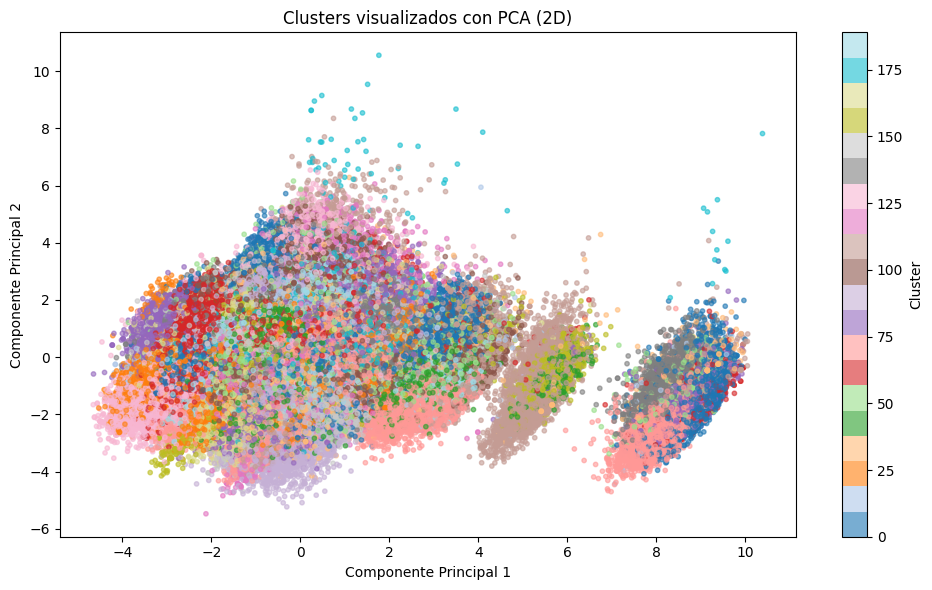

In [257]:
# PCA visual de todos los clusters
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df_cluster['cluster'], cmap='tab20', s=10, alpha=0.6)
plt.colorbar(scatter, label='Cluster')
plt.title("Clusters visualizados con PCA (2D)")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.tight_layout()
plt.show()

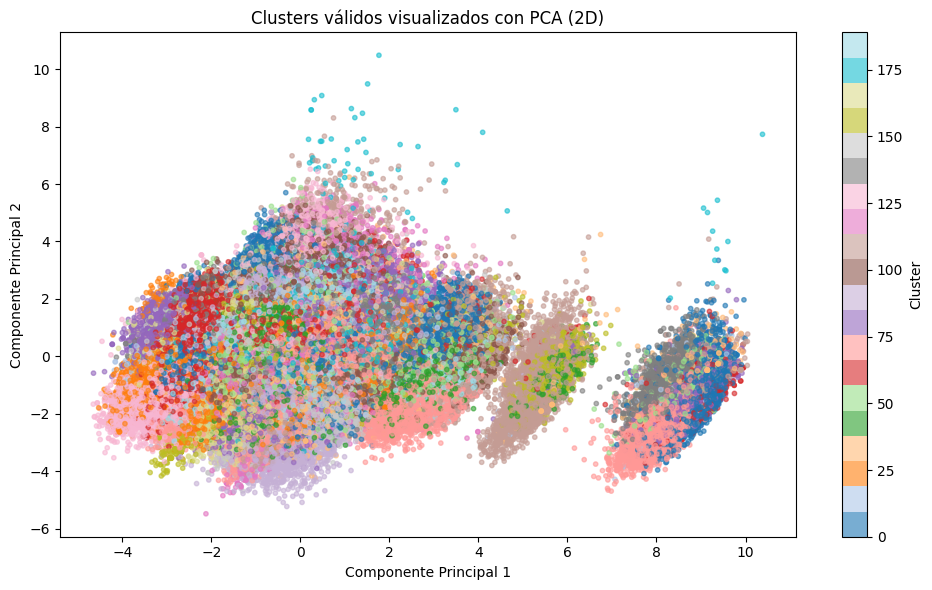

In [258]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Calcular el conteo de canciones por cluster
cluster_counts = df_cluster['cluster'].value_counts()

# Definir umbral mínimo y obtener clusters válidos
min_cluster_size = 100
clusters_validos = cluster_counts[cluster_counts >= min_cluster_size].index.tolist()

# Filtrar el DataFrame original con solo clusters válidos
df_filtrado = df_cluster[df_cluster['cluster'].isin(clusters_validos)]

# Escalar solo las features del subset filtrado
X_filtrado = df_filtrado[features]
X_filtrado_scaled = scaler.transform(X_filtrado)

# Luego aplica PCA
X_pca = pca.fit_transform(X_filtrado_scaled)

# Crear el gráfico
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    X_pca[:, 0], X_pca[:, 1],
    c=df_filtrado['cluster'],
    cmap='tab20',
    s=10,
    alpha=0.6
)
plt.colorbar(scatter, label='Cluster')
plt.title("Clusters válidos visualizados con PCA (2D)")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.tight_layout()
plt.show()
